importとか諸々

In [1]:
import pandas as pd
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/satoshiichikawa/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


データの読み込み

In [2]:
test = pd.read_csv('test.csv')
year1 = pd.read_csv('year1.csv')
year2 = pd.read_csv('year2.csv')
year3 = pd.read_csv('year2.csv')
year4 = pd.read_csv('year2.csv')

データをまとめる

In [311]:
all_data = pd.concat([year1,year2,year3,year4])

In [312]:
all_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,id,TARGET
0,0.20055,0.37951,0.39641,2.0472,32.351,0.38825,0.24976,1.3305,1.1389,0.50494,...,0.39718,0.87804,0.001924,8.416,5.1372,82.658,4.4158,7.4277,0,0
1,0.20912,0.49988,0.47225,1.9447,14.786,0,0.25834,0.99601,1.6996,0.49788,...,0.42002,0.853,0,4.1486,3.2732,107.35,3.4,60.987,1,0
2,0.24866,0.69592,0.26713,1.5548,-1.1523,0,0.30906,0.43695,1.309,0.30408,...,0.81774,0.76599,0.69484,4.9909,3.951,134.27,2.7185,5.2078,2,0
3,0.081483,0.30734,0.45879,2.4928,51.952,0.14988,0.092704,1.8661,1.0571,0.57353,...,0.14207,0.94598,0,4.5746,3.6147,86.435,4.2228,5.5497,3,0
4,0.18732,0.61323,0.2296,1.4063,-7.3128,0.18732,0.18732,0.6307,1.1559,0.38677,...,0.48431,0.86515,0.12444,6.3985,4.3158,127.21,2.8692,7.898,4,0


前処理

In [313]:
for i in all_data.iloc[:,0:-2]: 
  all_data[i] = all_data[i].replace(0,np.nan)
  all_data[i] = pd.to_numeric(all_data[i],errors='coerce')
all_data = all_data.fillna(all_data.mean())

In [314]:
for i in test.iloc[:,0:-1]:
  test[i] = test[i].replace(0,np.nan)
  test[i] = pd.to_numeric(test[i],errors='coerce')
test = test.fillna(test.mean())


In [315]:
def remove_outliers(df, q=0.005):
    upper = df.quantile(1-q)
    lower = df.quantile(q)
    mask = (df < upper) & (df > lower)
    return mask

mask = remove_outliers(all_data)
all_data.iloc[:,0:-2] = all_data[mask]
mask = remove_outliers(test)
test.iloc[:,0:-1] = test[mask]

all_data = all_data.fillna(all_data.mean())
test = test.fillna(test.mean())

In [316]:
# 取り除く列のリスト
not_use_columns = ['X37']
# 学習用データから列を削除する（PassengerIdは後ほど取り除く）
all_data.drop(not_use_columns, axis=1, inplace=True)
# テスト用データから列を削除する
test.drop(not_use_columns, axis=1, inplace=True)

In [317]:
all_data.info()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,id,TARGET
0,0.200550,0.379510,0.396410,2.047200,32.3510,0.388250,0.249760,1.330500,1.13890,0.504940,...,0.397180,0.87804,0.001924,8.416000,5.1372,82.6580,4.41580,7.42770,0,0
1,0.209120,0.499880,0.472250,1.944700,14.7860,0.000000,0.258340,0.996010,1.69960,0.497880,...,0.420020,0.85300,0.000000,4.148600,3.2732,107.3500,3.40000,60.98700,1,0
2,0.248660,0.695920,0.267130,1.554800,-1.1523,0.000000,0.309060,0.436950,1.30900,0.304080,...,0.817740,0.76599,0.694840,4.990900,3.9510,134.2700,2.71850,5.20780,2,0
3,0.081483,0.307340,0.458790,2.492800,51.9520,0.149880,0.092704,1.866100,1.05710,0.573530,...,0.142070,0.94598,0.000000,4.574600,3.6147,86.4350,4.22280,5.54970,3,0
4,0.187320,0.613230,0.229600,1.406300,-7.3128,0.187320,0.187320,0.630700,1.15590,0.386770,...,0.484310,0.86515,0.124440,6.398500,4.3158,127.2100,2.86920,7.89800,4,0
5,0.228220,0.497940,0.359690,1.750200,-47.7170,0.000000,0.281390,1.008300,1.97860,0.502060,...,0.454570,0.85891,0.023002,3.402800,8.9949,88.4440,4.12690,12.29900,5,0
6,0.111090,0.647440,0.289710,1.470500,2.5349,0.000000,0.111090,0.544540,1.73480,0.352560,...,0.315100,0.40871,0.000000,6.322200,2.9098,129.5500,2.81730,18.35200,6,0
7,0.532320,0.027059,0.705540,2.660415,299.5800,0.000000,0.652400,35.957000,0.65273,0.972940,...,0.547130,0.49521,0.013194,9.130000,82.0500,7.4503,48.99100,2.32170,7,0
8,0.009020,0.632020,0.053735,1.126300,-37.8420,0.000000,0.014434,0.582230,1.33320,0.367980,...,0.024512,0.84165,0.340940,9.966500,4.2382,116.5000,3.13300,2.56030,8,0
9,0.124080,0.838370,0.142040,1.169400,-91.8830,0.000000,0.153280,0.192790,2.11560,0.161630,...,0.767680,0.92847,0.000000,3.319200,6.4994,144.6300,2.52360,107.67000,9,0


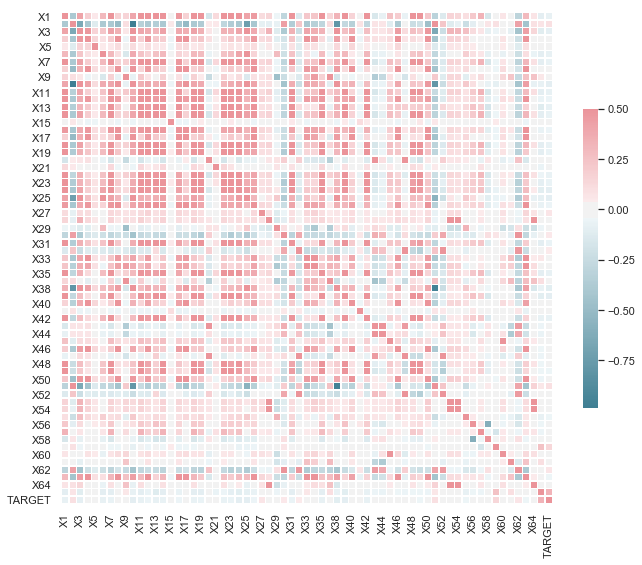

In [318]:
sns.set(style="white")
 
 
# Compute the correlation matrix
corr = all_data.corr()
 
 
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 11))
 
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
 
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
 
plt.show()

Xとyの決定

In [319]:
X = all_data.iloc[:, 0:-2]
test_X = test.iloc[:,0:-1]

In [320]:
y = all_data.loc[:, 'TARGET']

In [321]:
scaler = StandardScaler()
scaler.fit_transform(X)

array([[ 0.77912026, -0.43292835,  0.68051788, ..., -0.12856417,
        -0.3838719 , -0.19033733],
       [ 0.83118608, -0.04265761,  0.93564068, ...,  0.09075183,
        -0.50355431,  0.7421301 ],
       [ 1.07140578,  0.5929549 ,  0.245625  , ...,  0.32985709,
        -0.58384921, -0.22898579],
       ...,
       [-0.3476037 ,  0.14445318, -1.61037319, ...,  0.1520381 ,
        -0.52773114, -0.27751965],
       [-0.4548107 , -0.1370722 ,  0.7733632 , ..., -0.2917011 ,
        -0.23524092,  0.12254301],
       [-0.42670669,  1.39453865, -1.10625   , ...,  0.84714869,
        -0.68075684, -0.16372615]])

データを分割

In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Training done using Random Forest


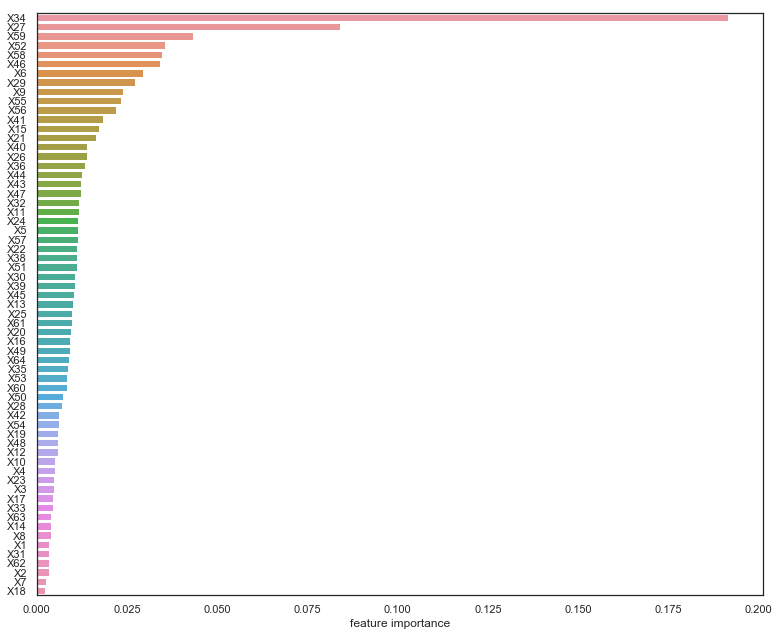

In [323]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print('Training done using Random Forest')
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

スタッキングを実装

In [325]:
from sklearn.linear_model import LogisticRegression
models = {
    ("RandomForest", RandomForestClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("NeuralNetwork", MLPClassifier(max_iter = 10000,)),
    ("AdaBoost", AdaBoostClassifier())
    }
for name, model in models:
    acc = accuracy_score(y_test, model.fit(X_train, y_train).predict(X_test))
    print("Accuracy of", name, ":", acc)

In [ ]:
from sklearn.ensemble import StackingClassifier
acc = accuracy_score(y_test, stacking.fit(X_train, y_train).predict(X_test))
print("Accuracy of Stacking :", acc)

csvに出力

In [ ]:
submission = pd.DataFrame({'id': test['id'], 'TARGET': pred})
submission.to_csv('submission.csv', index=False)